# 1.Regression
Here you'll find an example of how to predict values given some data and results.
An example of this would be to try and find a relationship between Temperature, Humidity and Dew Point.
We'll start working on how to predict a straight line and then move to the latter example.

It is advised to check out the "0.MachineLearningBasics.ipynb" before continuing

### 1.1 Imports

We will be using PyTorch for this, a quite popular framework that was built by facebook and is used by companies like Tesla or Microsoft. There's also the option of using Tensorflow, another popular framework built by Google. The decision of using pytorch is purely subjective but does allow some more in-depth tweaking of the models, what may come in handy.

For installation tutorial, check the pytorch website: https://pytorch.org/get-started/locally/

or if you want to use it in the browser, checkout the google collaborator version of this notebook:

In [532]:
# Import PyTorch and matplotlib
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.1.2+cu121'

Here we're gonna create device agnostic code. Is completely optional, but throughout this notebook we'll use it to allow for the use of a GPU if available

In [533]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


### 1.2 Creating of the Training Data

For this first example, we're gonna use a straight line, as it is a great way to understand what happens inside a neural network.

In [534]:
# Create weight and bias which act as the slope and independent value.
weight = 0.7
bias = 0.3

# Create range values, from where to where will our data go in the X axis
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors will happen later on (shapes within linear layers)
y = weight * X + bias 
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### 1.3 Splitting our data

When training an AI model, it is common to split the data between testing set and training set. This is because we want to give the AI only certain data and check the rest afterwards to see how it's performing. If we didn't do this, we would be evaluating our model with data it has already seen before, which is no good.

In [535]:
# importing a splitting function
from sklearn.model_selection import train_test_split
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

### 1.4 Creating our model

For this, we have two options:
1. Using a python class, which will allow more customizability, but is more complicated to use.
2. Building it sequentially, which is the opposite.

If it's the first time you've ever build a model, Option 2 may be a better starting point

#### Option 1

In [536]:
# Subclass nn.Module to make our model
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1, 
                                      out_features=1)
    
    # Define the forward computation (input data x flows through nn.Linear())
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# Set the manual seed when creating the model (this isn't always need but is used for demonstrative purposes, try commenting it out and seeing what happens)
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

#### Option 2

In [537]:
model_1 = nn.Sequential(
    nn.Linear(in_features=1, out_features=1) # 1 layer with one neuron. So we are essentially doing a Linear regression: Y = wx + b
)
model_1

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
)

In [538]:
# Set model to GPU if it's availalble, otherwise it'll default to CPU
model_1.to(device) # the device variable was set above to be "cuda" if available or "cpu" if not
next(model_1.parameters()).device

device(type='cuda', index=0)

### 1.5 Choosing a Loss Function and Optimizer

When training and evaluating a model, a Loss function will determine how "wrong" the model got the answer. This is a way of then telling the optimizer to make a "step" and update the weights and biases (slopes and independent values of our model) to minimize the error.

Essentially we are solving an optimization problem, where the function to optimize is the one we choose as our Loss Function

To know what to use or which ones are available, check: https://pytorch.org/docs/stable/nn.html#loss-functions for Loss Functions

and : https://pytorch.org/docs/stable/optim.html for optimizers 

In [539]:
# Create loss function
loss_fn = nn.L1Loss() # aka. Mean Absolute Error

# Create optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), # optimize newly created model's parameters
                            lr=0.01) # lr is the learning rate, which tells the model how much to update the weights and biases each iteration
                                     # a big learning rate will make to big of a step every time and so it will never settle on a value.
                                     # a small learning rate will take forever to converge or settle on a value

### 1.6 Training Our Model

In [540]:
# Set the number of epochs (aka. number of iterations through the training data)
epochs = 1000 

# Put data on the available device
# Without this, error will happen (not all model/data on device)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train() # train mode is on by default after construction

    # 1. Forward pass (aka. we predict new data)
    y_pred = model_1(X_train)

    # 2. Calculate loss (aka. we see how wrong this data is)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad optimizer (this is for the optimizer to start fresh each iteration. It is needed)
    optimizer.zero_grad()

    # 4. Loss backward (aka. we apply backpropagation. We calculate how wrong each weight and slope is in our model)
    loss.backward()

    # 5. Step the optimizer (aka. we update the weights and biases according to our learning rate and how wrong they are)
    optimizer.step()

    ### Testing (aka. see how good the model is when it predicts our testing data)
    model_1.eval() # put the model in evaluation mode for testing (inference)
    # 1. Forward pass
    with torch.inference_mode():
        test_pred = model_1(X_test)
    
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.2535172700881958 | Test loss: 0.2910796105861664
Epoch: 100 | Train loss: 0.19376806914806366 | Test loss: 0.22988806664943695
Epoch: 200 | Train loss: 0.14788547158241272 | Test loss: 0.17533186078071594
Epoch: 300 | Train loss: 0.10200285911560059 | Test loss: 0.12077567726373672


Epoch: 400 | Train loss: 0.05612315610051155 | Test loss: 0.06616974622011185
Epoch: 500 | Train loss: 0.010240399278700352 | Test loss: 0.011613413691520691
Epoch: 600 | Train loss: 0.005713563412427902 | Test loss: 0.006527513265609741
Epoch: 700 | Train loss: 0.005713563412427902 | Test loss: 0.006527513265609741
Epoch: 800 | Train loss: 0.005713563412427902 | Test loss: 0.006527513265609741
Epoch: 900 | Train loss: 0.005713563412427902 | Test loss: 0.006527513265609741


In [541]:
# Find our model's learned parameters (aka. weights and biases)
print("The model learned the following values for weights and bias:")
print(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('0.weight', tensor([[0.6972]], device='cuda:0')), ('0.bias', tensor([0.3071], device='cuda:0'))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


### 1.7 Making new predictions with our data

Now it's time to predict new data with our model

In [542]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.8509],
        [0.8649],
        [0.4047],
        [0.8927],
        [0.3908],
        [0.4744],
        [0.4605],
        [0.5720],
        [0.8788],
        [0.5442]], device='cuda:0')

### 1.8 Saving and Loading a Model

If you don't want to be training the model constantly every time you want to use it, you can save it to a .pth file as follows

In [543]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "Regression_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models\Regression_model_1.pth


To load back our model, we need to first create an empty model and then load our weights and biases into it

In [544]:
# Instantiate a fresh instance of LinearRegressionModelV2

loaded_model_1 = LinearRegressionModelV2()
# or
loaded_model_1 = nn.Sequential(
    nn.Linear(in_features=1, out_features=1)
)

# Load model state dict 
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cuda:0


### 1.9 What just happened?

Our model was trained using data we created following the straight line Y = 0.7x + 0.3. From where we got a list of X and Y values.

These X and Y values where feed 1000 times into the model and by adjusting ever so slightly to reduce the loss function.

If curious how this optimization phase works, you can check out 3b1b's video series on the matter: https://youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&si=nHw9qdHeDoAwVA0N


### 1.10 Weather Model

Now we're going to apply the latter to build a model to predict the dew point given humidity, temperature and preassure

As we are now going to use a dataset, we'll use a python library called pandas, that will allow us to analyze and better store the data

In [545]:
import pandas as pd
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.1.2+cu121'

In [546]:
data = pd.read_csv('./data/LCD_sample_csv.csv') # Source: National Centers for Environmental Information (ncei.noaa.gov)
data.describe()

,ELEVATION,LATITUDE,LONGITUDE,HourlyVisibility,HourlyDryBulbTemperatureF,HourlyDryBulbTemperatureC,HourlyWetBulbTemperatureF,HourlyWetBulbTemperatureC,HourlyDewPointTemperatureF,HourlyDewPointTemperatureC,HourlyRelativeHumidity,HourlyWindSpeed,HourlyStationPressure,HourlyAltimeterSetting,DailySunrise,DailySunset
count,7.420000e+02,7.420000e+02,7.420000e+02,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000
mean,2.018000e+02,4.199500e+01,-8.793360e+01,9.230121,31.628032,-0.208356,27.723720,-2.368868,18.384097,-7.564825,59.570081,10.994609,29.321954,30.041011,1183.549865,1201.628032
std,5.688176e-14,7.110220e-15,1.422044e-14,2.032510,12.196620,6.778430,11.076008,6.151487,11.859361,6.587330,13.185066,5.668529,0.239476,0.244406,33.919482,1171.760435
min,2.018000e+02,4.199500e+01,-8.793360e+01,0.500000,-1.000000,-18.300000,-2.000000,-19.200000,-17.000000,-27.200000,24.000000,0.000000,28.690000,29.400000,1135.000000,0.000000
25%,2.018000e+02,4.199500e+01,-8.793360e+01,10.000000,22.000000,-5.600000,19.000000,-7.200000,9.000000,-12.800000,51.000000,7.000000,29.130000,29.850000,1149.000000,8.000000
50%,2.018000e+02,4.199500e+01,-8.793360e+01,10.000000,32.000000,0.000000,28.500000,-1.950000,20.000000,-6.700000,61.000000,10.000000,29.350000,30.070000,1202.000000,2342.000000
75%,2.018000e+02,4.199500e+01,-8.793360e+01,10.000000,40.000000,4.400000,36.000000,2.000000,28.000000,-2.200000,70.000000,15.000000,29.510000,30.230000,1215.500000,2351.000000
max,2.018000e+02,4.199500e+01,-8.793360e+01,10.000000,67.000000,19.400000,59.000000,15.200000,47.000000,8.300000,89.000000,29.000000,29.740000,30.470000,1227.000000,2359.000000


This dataset contains way too much information that we do not need, so lets clean up the redundant info

In [547]:
data.dropna()
data.describe()

,ELEVATION,LATITUDE,LONGITUDE,HourlyVisibility,HourlyDryBulbTemperatureF,HourlyDryBulbTemperatureC,HourlyWetBulbTemperatureF,HourlyWetBulbTemperatureC,HourlyDewPointTemperatureF,HourlyDewPointTemperatureC,HourlyRelativeHumidity,HourlyWindSpeed,HourlyStationPressure,HourlyAltimeterSetting,DailySunrise,DailySunset
count,7.420000e+02,7.420000e+02,7.420000e+02,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000
mean,2.018000e+02,4.199500e+01,-8.793360e+01,9.230121,31.628032,-0.208356,27.723720,-2.368868,18.384097,-7.564825,59.570081,10.994609,29.321954,30.041011,1183.549865,1201.628032
std,5.688176e-14,7.110220e-15,1.422044e-14,2.032510,12.196620,6.778430,11.076008,6.151487,11.859361,6.587330,13.185066,5.668529,0.239476,0.244406,33.919482,1171.760435
min,2.018000e+02,4.199500e+01,-8.793360e+01,0.500000,-1.000000,-18.300000,-2.000000,-19.200000,-17.000000,-27.200000,24.000000,0.000000,28.690000,29.400000,1135.000000,0.000000
25%,2.018000e+02,4.199500e+01,-8.793360e+01,10.000000,22.000000,-5.600000,19.000000,-7.200000,9.000000,-12.800000,51.000000,7.000000,29.130000,29.850000,1149.000000,8.000000
50%,2.018000e+02,4.199500e+01,-8.793360e+01,10.000000,32.000000,0.000000,28.500000,-1.950000,20.000000,-6.700000,61.000000,10.000000,29.350000,30.070000,1202.000000,2342.000000
75%,2.018000e+02,4.199500e+01,-8.793360e+01,10.000000,40.000000,4.400000,36.000000,2.000000,28.000000,-2.200000,70.000000,15.000000,29.510000,30.230000,1215.500000,2351.000000
max,2.018000e+02,4.199500e+01,-8.793360e+01,10.000000,67.000000,19.400000,59.000000,15.200000,47.000000,8.300000,89.000000,29.000000,29.740000,30.470000,1227.000000,2359.000000


In [548]:
data_labels = ["HourlyDryBulbTemperatureC", "HourlyDewPointTemperatureC", "HourlyStationPressure", "HourlyRelativeHumidity"]
data = data[data_labels]
data.head()

,HourlyDryBulbTemperatureC,HourlyDewPointTemperatureC,HourlyStationPressure,HourlyRelativeHumidity
0,-1.1,-8.9,29.28,56
1,-1.1,-8.3,29.27,58
2,-1.7,-6.1,29.28,72
3,-2.2,-5.0,29.29,81
4,-3.3,-6.7,29.32,78


Now, we could try and see what relationships there are between the data. Is Preassure related to the dewpoint? And temperature?

Text(0, 0.5, '%')

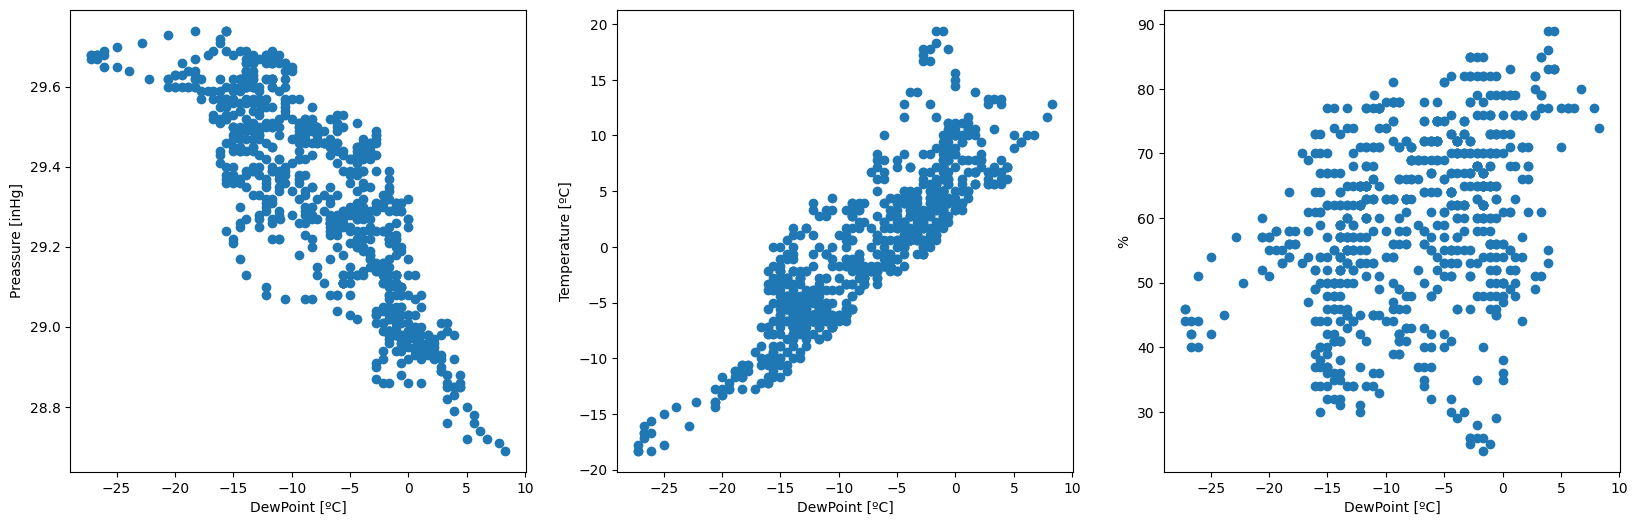

In [549]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.scatter(data["HourlyDewPointTemperatureC"], data["HourlyStationPressure"]) 
plt.xlabel("DewPoint [ºC]")
plt.ylabel("Preassure [inHg]")


plt.subplot(1, 3, 2)
plt.scatter(data["HourlyDewPointTemperatureC"], data["HourlyDryBulbTemperatureC"]) 
plt.xlabel("DewPoint [ºC]")
plt.ylabel("Temperature [ºC]")

plt.subplot(1, 3, 3)
plt.scatter(data["HourlyDewPointTemperatureC"], data["HourlyRelativeHumidity"]) 
plt.xlabel("DewPoint [ºC]")
plt.ylabel("%")

For preassures we can clearly see a negative correlation: With lower preassures, higher dewpoints.
And for temperatures, also a positive correlation.
Humidity does not present a remarkable relationship, but a positive one can still be seen

### 1.11 Splitting the data and building the model

Now, let's get to work and build the model we're going to use to predict dewpoints from temperature and preassure values

To make it simpler we're gonna use a Sequential Model, but it could be done with a class too

In [550]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [551]:
weather_model_0 = nn.Sequential(
    nn.Linear(in_features=3, out_features=1) # We have 3 Data points from which we want to predict 1 data point
).to(device)

In [552]:
weather_model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.5090, -0.4236,  0.5018]], device='cuda:0')),
             ('0.bias', tensor([0.1081], device='cuda:0'))])

All of our data is in the panda's format, so let's convert it into PyTorch Tensors

In [553]:
DewPoint = data.pop("HourlyDewPointTemperatureC")
tensor_data = torch.from_numpy(data.to_numpy()).to(device).type(torch.float)
tensor_DewPoint = torch.from_numpy(DewPoint.to_numpy()).to(device).type(torch.float).unsqueeze(dim=1)
tensor_data.shape, DewPoint.shape

(torch.Size([742, 3]), (742,))

In [554]:
# importing a splitting function
from sklearn.model_selection import train_test_split
# Split data

X_train, X_test, y_train, y_test = train_test_split(tensor_data, tensor_DewPoint, test_size=0.2)

len(X_train), len(y_train), len(X_test), len(y_test)
X_train.shape

torch.Size([593, 3])

### 1.12 Training the model

In [555]:
# Create loss function
loss_fn = nn.L1Loss()

# Create optimizer
optimizer = torch.optim.SGD(params=weather_model_0.parameters(), lr=0.001)

In [556]:
# Set the number of epochs (aka. number of iterations through the training data)
epochs = 1000 

# Put data on the available device
# Without this, error will happen (not all model/data on device)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    weather_model_0.train()

    y_pred = weather_model_0(X_train)

    loss = loss_fn(y_pred, y_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    weather_model_0.eval()
    with torch.inference_mode():
        test_pred = weather_model_0(X_test)
    
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 25.09847640991211 | Test loss: 20.41942024230957
Epoch: 100 | Train loss: 2.5585339069366455 | Test loss: 1.656167984008789


Epoch: 200 | Train loss: 2.568514108657837 | Test loss: 1.7460651397705078
Epoch: 300 | Train loss: 2.511178970336914 | Test loss: 1.8405499458312988
Epoch: 400 | Train loss: 2.4307548999786377 | Test loss: 1.9238007068634033
Epoch: 500 | Train loss: 2.346048593521118 | Test loss: 2.0044870376586914
Epoch: 600 | Train loss: 2.2999162673950195 | Test loss: 2.0559799671173096
Epoch: 700 | Train loss: 2.2380177974700928 | Test loss: 2.1266753673553467
Epoch: 800 | Train loss: 2.1650736331939697 | Test loss: 2.1628470420837402
Epoch: 900 | Train loss: 2.1307260990142822 | Test loss: 2.206362009048462


### 1.13 Evaluating the model
We can clearly see that the model has converged, so let's see how good it is

In [557]:
data.head()

,HourlyDryBulbTemperatureC,HourlyStationPressure,HourlyRelativeHumidity
0,-1.1,29.28,56
1,-1.1,29.27,58
2,-1.7,29.28,72
3,-2.2,29.29,81
4,-3.3,29.32,78


In [558]:
w0 = weather_model_0.state_dict()["0.weight"][0][0].item()
w1 = weather_model_0.state_dict()["0.weight"][0][1].item()
w2 = weather_model_0.state_dict()["0.weight"][0][2].item()
b = weather_model_0.state_dict()["0.bias"][0].item()
w0, w1, w2, b

(0.7925184965133667,
 -0.7633261680603027,
 0.21451272070407867,
 0.09681210666894913)

from the weights, we can deduce that the temperature has a positive relationship with the DewPoint, as it has a positive weight (first weight of the above).
The Preassure has a negative relationship and humidity positive but not as strong.
This proves our initial analysis as show again with the graphs below.

Text(0, 0.5, '%')

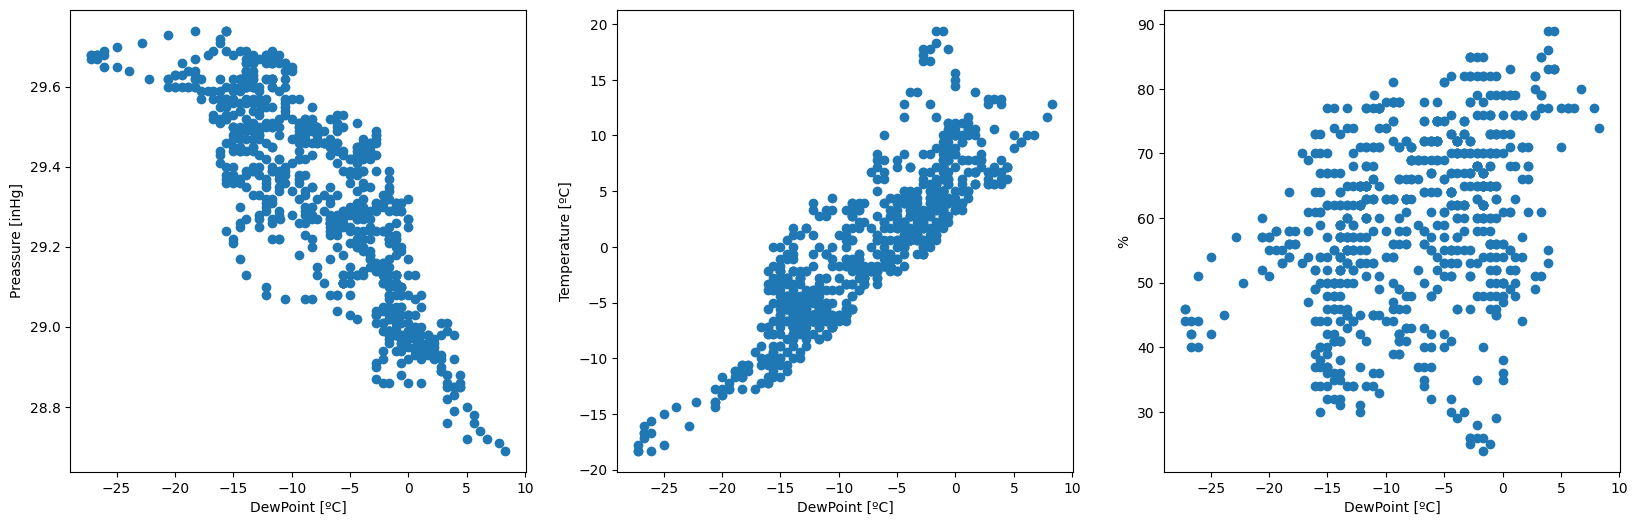

In [559]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.scatter(DewPoint, data["HourlyStationPressure"]) 
plt.xlabel("DewPoint [ºC]")
plt.ylabel("Preassure [inHg]")


plt.subplot(1, 3, 2)
plt.scatter(DewPoint, data["HourlyDryBulbTemperatureC"]) 
plt.xlabel("DewPoint [ºC]")
plt.ylabel("Temperature [ºC]")

plt.subplot(1, 3, 3)
plt.scatter(DewPoint, data["HourlyRelativeHumidity"]) 
plt.xlabel("DewPoint [ºC]")
plt.ylabel("%")

we can also check the mean absolute error using our testing set:

In [561]:
from sklearn.metrics import mean_absolute_error
# Turn model into evaluation mode
weather_model_0.eval()
# Make predictions on the test data
with torch.inference_mode():
    y_preds = weather_model_0(X_test)
y_preds_numpy = y_preds.cpu().numpy()
y_test_numpy = y_test.cpu().numpy()
print(f"Mean Absolute Error: {mean_absolute_error(y_test_numpy, y_preds_numpy)}")

Mean Absolute Error: 2.1237306594848633


### 1.14 How to improve the model?

There are several options when trying to improve our model:
* Using more Hidden Layers
* Train for longer (more epochs)
* Using more data (if available)
* Using Non-Linear regressions

to facilitate the following methods, I'm gonna define a function to train the model, so that we are not copying everying every time

In [685]:
def train_model(model, loss_fn, optimizer, epochs=1000):
    global X_train, y_train, y_pred, X_test
    for epoch in range(epochs):
        model.train()

        y_pred = model(X_train)

        loss = loss_fn(y_pred, y_train)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        model.eval()
        with torch.inference_mode():
            test_pred = model(X_test)
        
            test_loss = loss_fn(test_pred, y_test)

        if epoch % 100 == 0:
            print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

##### 1.14.1 Using more Hidden Layers

In [575]:
weather_model_1 = nn.Sequential(
    nn.Linear(in_features=3, out_features=8),
    nn.Linear(in_features=8, out_features=1)
).to(device)

In [577]:
train_model(model=weather_model_1, loss_fn=nn.L1Loss(), optimizer=torch.optim.SGD(params=weather_model_1.parameters(), lr=0.001))

Epoch: 0 | Train loss: 7.340668678283691 | Test loss: 6.714442253112793
Epoch: 100 | Train loss: 3.896953821182251 | Test loss: 3.618457794189453
Epoch: 200 | Train loss: 3.5506598949432373 | Test loss: 2.15268874168396
Epoch: 300 | Train loss: 2.706245183944702 | Test loss: 1.8551849126815796
Epoch: 400 | Train loss: 2.171288251876831 | Test loss: 1.657573938369751
Epoch: 500 | Train loss: 1.7754206657409668 | Test loss: 1.5404307842254639
Epoch: 600 | Train loss: 1.5233755111694336 | Test loss: 1.3761506080627441
Epoch: 700 | Train loss: 1.3725961446762085 | Test loss: 1.2514433860778809
Epoch: 800 | Train loss: 1.220037579536438 | Test loss: 1.1500192880630493
Epoch: 900 | Train loss: 1.1221071481704712 | Test loss: 1.0730825662612915


We can clearly see a reduction in the loss in comparison with the old model

##### 1.14.2 Training for longer

In [581]:
weather_model_0 = nn.Sequential(
    nn.Linear(in_features=3, out_features=1)
).to(device) # Same model as before

In [582]:
train_model(model=weather_model_0, loss_fn=nn.L1Loss(), optimizer=torch.optim.SGD(params=weather_model_0.parameters(), lr=0.001), epochs=2000)

Epoch: 0 | Train loss: 26.8090763092041 | Test loss: 22.22393035888672
Epoch: 100 | Train loss: 2.1608002185821533 | Test loss: 2.139124631881714
Epoch: 200 | Train loss: 3.1767332553863525 | Test loss: 1.1565651893615723
Epoch: 300 | Train loss: 3.363969564437866 | Test loss: 0.9918241500854492
Epoch: 400 | Train loss: 3.236999750137329 | Test loss: 1.137007236480713
Epoch: 500 | Train loss: 3.0447752475738525 | Test loss: 1.3344372510910034
Epoch: 600 | Train loss: 2.9048497676849365 | Test loss: 1.4685781002044678
Epoch: 700 | Train loss: 2.739445686340332 | Test loss: 1.6200255155563354
Epoch: 800 | Train loss: 2.498448371887207 | Test loss: 1.863860845565796
Epoch: 900 | Train loss: 2.373223066329956 | Test loss: 1.9890661239624023
Epoch: 1000 | Train loss: 2.255051851272583 | Test loss: 2.1108860969543457
Epoch: 1100 | Train loss: 2.176129102706909 | Test loss: 2.1528775691986084
Epoch: 1200 | Train loss: 2.1514806747436523 | Test loss: 2.2105910778045654
Epoch: 1300 | Train loss

where it did improve ever so slightly, but not that much as it had already converged

##### 1.14.3 Using more data (if available)

we can't really show this in this model as we do not have access to more data (we are using all of what we have), but we can show what would happen if we reduce the amount of data

In [604]:
less_data = data[:300] # only first 300
less_DewPoints = DewPoint[:300]
less_data.describe()

,HourlyDryBulbTemperatureC,HourlyStationPressure,HourlyRelativeHumidity
count,300.000000,300.000000,300.000000
mean,-3.753000,29.377633,62.326667
std,6.840751,0.244754,10.572886
min,-18.300000,28.920000,37.000000
25%,-8.300000,29.200000,54.750000
50%,-5.000000,29.440000,63.000000
75%,1.250000,29.592500,71.000000
max,11.700000,29.740000,85.000000


In [605]:
weather_model_0 = nn.Sequential(
    nn.Linear(in_features=3, out_features=1)
).to(device) # Same model as before

In [606]:
# importing a splitting function
from sklearn.model_selection import train_test_split
# Split data

tensor_data = torch.from_numpy(less_data.to_numpy()).to(device).type(torch.float)
tensor_DewPoint = torch.from_numpy(less_DewPoints.to_numpy()).to(device).type(torch.float).unsqueeze(dim=1)

X_train, X_test, y_train, y_test = train_test_split(tensor_data, tensor_DewPoint, test_size=0.2)

len(X_train), len(y_train), len(X_test), len(y_test)
X_train.shape, y_train.shape

(torch.Size([240, 3]), torch.Size([240, 1]))

In [607]:
train_model(model=weather_model_0, loss_fn=nn.L1Loss(), optimizer=torch.optim.SGD(params=weather_model_0.parameters(), lr=0.001))

Epoch: 0 | Train loss: 8.186518669128418 | Test loss: 6.888984203338623
Epoch: 100 | Train loss: 5.01390266418457 | Test loss: 4.3356499671936035
Epoch: 200 | Train loss: 2.725486993789673 | Test loss: 2.593536376953125
Epoch: 300 | Train loss: 1.5810418128967285 | Test loss: 2.3296408653259277
Epoch: 400 | Train loss: 1.3299658298492432 | Test loss: 3.2869229316711426
Epoch: 500 | Train loss: 1.081018090248108 | Test loss: 3.496824264526367
Epoch: 600 | Train loss: 0.9870669841766357 | Test loss: 3.532650947570801
Epoch: 700 | Train loss: 0.9503712058067322 | Test loss: 3.7171432971954346
Epoch: 800 | Train loss: 1.016397476196289 | Test loss: 3.741940498352051
Epoch: 900 | Train loss: 0.9158197045326233 | Test loss: 3.748814821243286


where it would look like it's better because of the train loss, but when looking at the test loss, which is the one using the testing set and so the one we care about, we clearly see it's higher

##### 1.14.3 Using Non-Linear Regressions

What if the data doesn't follow lines but a quadratic equation? Try giving the model more datapoints which are the squares, cubes, sines, exponentials of the other datapoints. That's because if the equation the data follows is Y = ax^2 + bx + c, we could convert it into a linear equation just by saying Z = x^2. Now Y = aZ + bx + c, where Z and x are datapoints